In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

In [2]:
#txt_to_numpy a small helper function that taxes a filename and returns a matrix of floats from the file with that name
def txt_to_numpy(filename):
    a_file = open(filename)
    file_contents = a_file.read()
    contents_split = file_contents.splitlines()
    array=[]
    for i in range(len(contents_split)):
        array.append( np.array([x for x in contents_split[i].split(',')]))
    return np.array(array).astype(float)

In [3]:
#read in training dataset and labels
training_set=txt_to_numpy("handwriting_training_set.txt")
training_labels=txt_to_numpy("handwriting_training_set_labels.txt")
#read in test dataset and labels
test_set=txt_to_numpy("handwriting_test_set.txt")
test_labels=txt_to_numpy("handwriting_test_set_labels.txt")

Check Dimensions of read data 

In [4]:
print("Dimensions of training set:",np.shape(training_set))
print("Dimensions of training labels:",np.shape(training_labels))
print("Dimensions of test set:",np.shape(test_set))
print("Dimensions of test labels:",np.shape(test_labels))

Dimensions of training set: (4000, 400)
Dimensions of training labels: (4000, 1)
Dimensions of test set: (1000, 400)
Dimensions of test labels: (1000, 1)


Plotting a single entry in the data matrix 

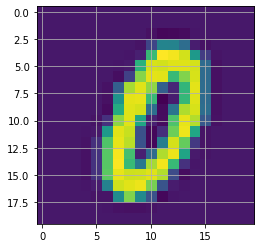

In [5]:
number=training_set[2]
number=np.reshape(number,(20,20)) 
plt.imshow(number.T, cmap=plt.get_cmap('viridis')) 
plt.grid()

Split the data matrices into ten distinct 400x400 matrices one for each digit 0-9

In [6]:
training_digits=np.split(training_set,10)
for i in range(10):
    training_digits[i]=training_digits[i].T

Compute SVD for each digit matrix and store the resulting decomposition in a respective Us,Ss,Vs, matrix for each access

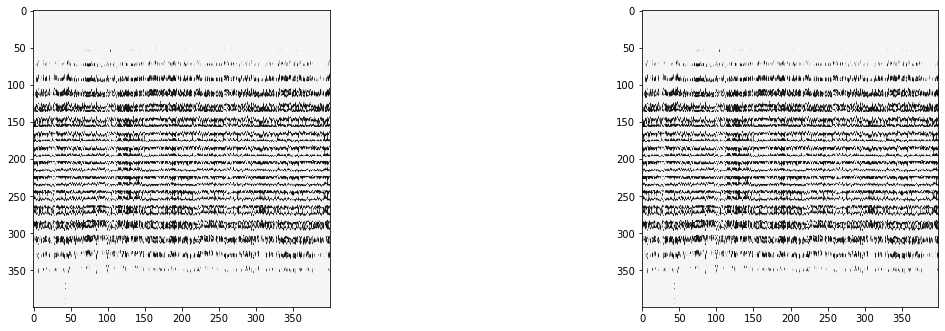

In [7]:
sample_digit=0
#Plot starting data for comparison to SVD reconstruction
fig = plt.figure(figsize=(20, 12))
fig.add_subplot(2, 2, 1)
plt.imshow(training_digits[sample_digit], cmap='Greys', interpolation='nearest')

#initialize lists for storing the decompositions for each digit matrix
L_singular_vectors=[]
Sigma_matrices=[]
R_singular_vectors=[]
 
#Compute the SVD fr each digit and store the resulting matrices that form the decomposition in a new matrix 
for i in range(10):
    #compute svd for the digit  i 
    u,s,v = la.svd(training_digits[i],full_matrices=False)
    L_singular_vectors.append(u.T)
    Sigma_matrices.append(s)# use np.diag(S) for nxn matrix of singular values 
    R_singular_vectors.append(v)
    
#conver the lists to numpy arrays after storing all of the decompositions
Us=np.array(L_singular_vectors).astype(float)
Ss=np.array(Sigma_matrices).astype(float)
Vs=np.array(R_singular_vectors).astype(float)

fig.add_subplot(2, 2, 2)
plt.imshow(Us[sample_digit].T*Ss[sample_digit]@Vs[sample_digit], cmap='Greys', interpolation='nearest')

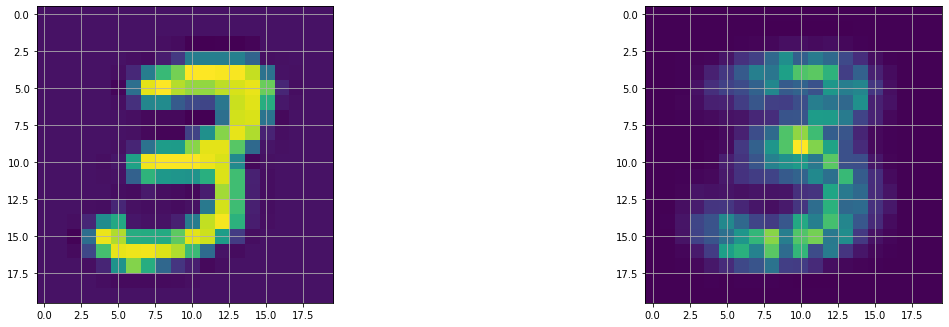

In [8]:
#This structure allows us to use nested indicies to reference parts of the various svds computed
# For instance the first unitary vector for digit 0 is Us[0][1] etc,

digit=3
sample=0

control=np.reshape(training_set[digit*400+sample],(20,20))
#PLOT test entry 
fig = plt.figure(figsize=(20, 12))
fig.add_subplot(2, 2, 1)
plt.imshow(control.T, cmap=plt.get_cmap('viridis')) 
plt.grid()

#compute svd reconstructed entry
data_test=Ss[digit][sample]*Us[digit][sample]*Vs[digit][sample]
data_test=np.reshape(data_test,(20,20))  

#PLOT
fig.add_subplot(2, 2, 2)
plt.grid()
plt.imshow(data_test.T, cmap=plt.get_cmap('viridis')) 

## Part A

In [28]:
# Classification function, returns the classification of a given sample based on the norm of the orthogonal complement
# this methodology allows us to quantify similarity by examining how far away each test sample is from the orthonormal basis 
# associated with each digit matrix picking the one with the smallest distance

def classify_y(Us, y, r):
    min_val = float('inf')
    classification = 0
    U_rs = [U[:r] for U in Us]
    for i,U_r in enumerate(U_rs):
        x_i = la.solve(U_r@U_r.T,U_r@y)
        diff = la.norm(y-U_r.T@x_i)
        if diff < min_val:
            min_val = diff
            if(i==0):
                classification=10
            else:
                classification = i
    return classification

In [29]:
# A small printing function used for printing digits as human interpretable images
def print_digit(y):
    fig = plt.figure(figsize=(20, 12))
    fig.add_subplot(2, 2, 1)
    plt.imshow(y.reshape(20,20).T, cmap=plt.get_cmap('viridis')) 
    plt.grid()
    plt.show()

In [30]:

def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

testing  5  basis vectors


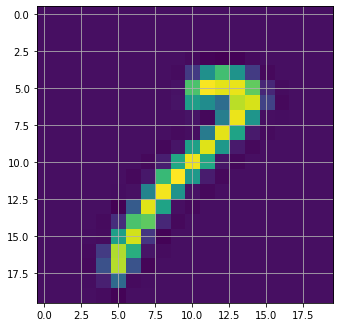

1 [7.]


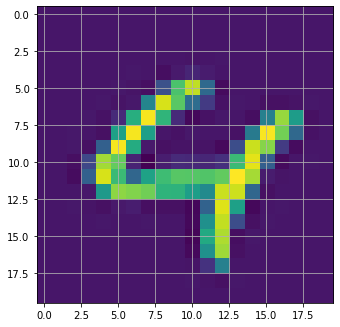

9 [4.]


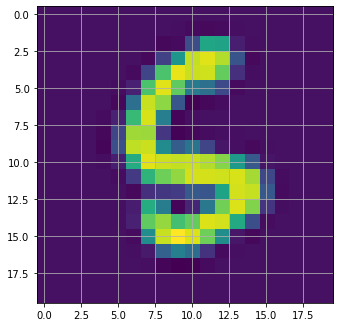

6 [5.]


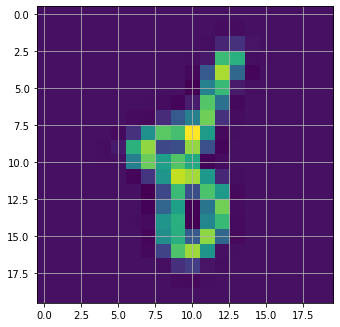

1 [8.]
testing  10  basis vectors


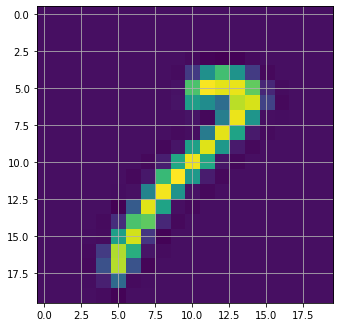

1 [7.]


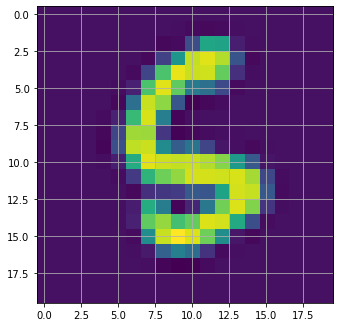

6 [5.]


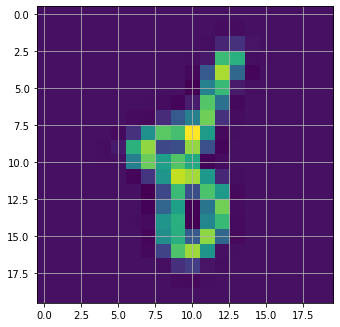

1 [8.]
testing  15  basis vectors


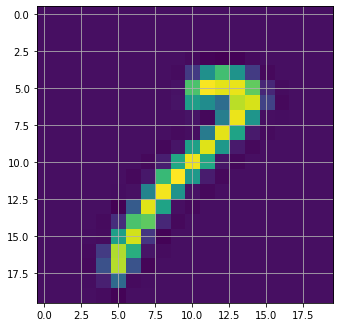

8 [7.]


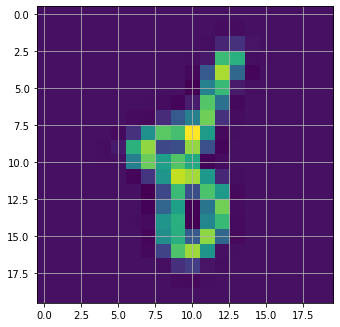

1 [8.]
testing  20  basis vectors


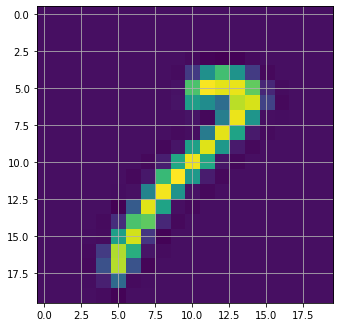

8 [7.]


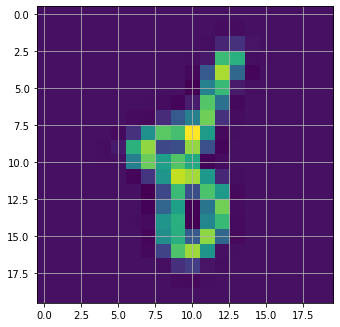

1 [8.]
[82, 56, 47, 43]


In [93]:
#Classify the test digits using the SVD of the training digits for varying numbers of basis vectors. 
#store number of incorrect samples into a matrix to be plotted at a later date
incorrect_samples=0
basis_performance=[]
Basis_errors=[[],[],[],[],[]]

for j in range(1,5):
    print("testing ",5*j," basis vectors")
    
    incorrect_classification=[]
    Classifications=[]
    num_basis_vecs=5*j
    
    #classify test data
    for i in range(1000):
        Classifications.append(classify_y(Us,test_set[i],num_basis_vecs)) 
        
    #count failed classifications
    for i in range(1000):
        if Classifications[i]!=test_labels[i]:
            incorrect_classification.append(Classifications[i])
            if(i%42==0):
                print_digit(test_set[i])
                print(Classifications[i],test_labels[i])
            incorrect_samples=incorrect_samples+1  
            
    for i in range(0,10):
      
        if i==0:
            error=countX(incorrect_classification,10)/incorrect_samples
            #print("Percentage of errors that are 0:",error)
        else:
            error=countX(incorrect_classification,i)/incorrect_samples
            #print("Percentage of errors that are",i,":",error)
        Basis_errors[j].append(error)   
    
   
    #cache performance for a set of basis vectors and reset for the next attempt        
    basis_performance.append(incorrect_samples)
    incorrect_samples=0
    print("=======================")
print(basis_performance)

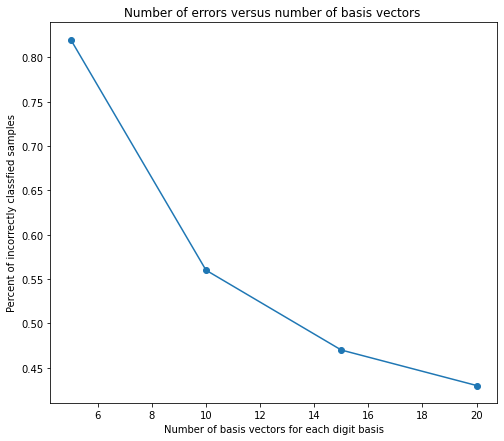

In [84]:
#Plot the results for different singular vector quantities
fig = plt.figure(figsize=(8, 7))
x=np.array(([5,10,15,20]))
plt.plot(x,(1/100*np.asarray(basis_performance)),'o-')
plt.title("Number of errors versus number of basis vectors ")
plt.xlabel("Number of basis vectors for each digit basis")
plt.ylabel("Percent of incorrectly classfied samples")
plt.show()

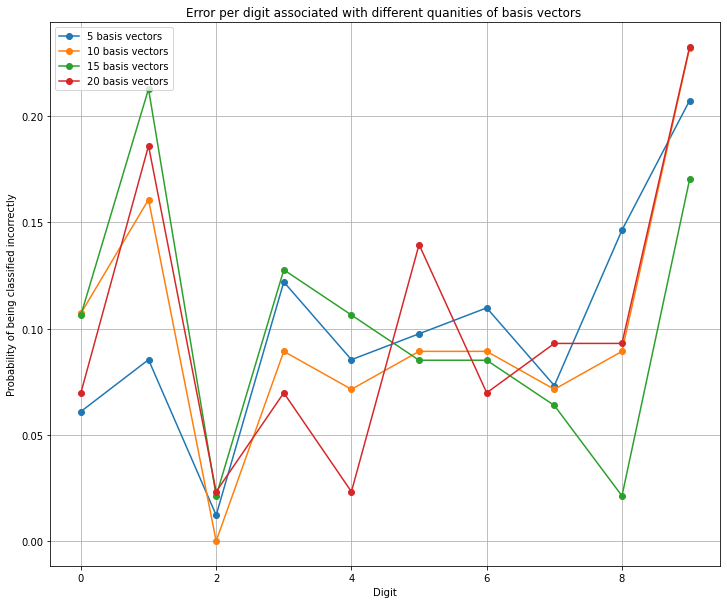

In [63]:

#show behavior of different basis with each digit
fig, ax = plt.subplots(figsize=(12, 10))
x=np.arange(10)
plt.title("Error per digit associated with different quanities of basis vectors ")
plt.xlabel("Digit")
plt.ylabel("Probability of being classified incorrectly")

ax.plot(x,Basis_errors[1],'o-',label ="5 basis vectors")
ax.plot(x,Basis_errors[2],'o-',label ="10 basis vectors")
ax.plot(x,Basis_errors[3],'o-',label ="15 basis vectors")
ax.plot(x,Basis_errors[4],'o-',label ="20 basis vectors")
plt.legend(['5 basis vectors', '10 basis vectors', '15 basis vectors', '20 basis vectors'], loc='upper left')
plt.grid()    
plt.show()

Text(0, 0.5, 'Number of singular values')

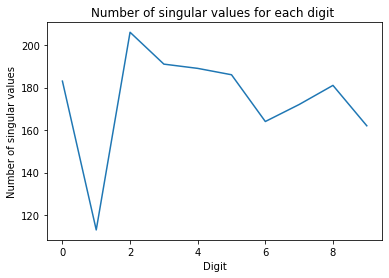

In [39]:
#Show singular values for each digit
singular_values=[]

for i in range(10):
    num_singular=0
    for j in range(400):
        if(Ss[i][j].round()>0):
            num_singular+=1
    singular_values.append(num_singular)
    #print("For digit",i,"there are:",num_singular,"Singular values")
plt.plot(np.arange(10),singular_values)  
plt.title("Number of singular values for each digit ")
plt.xlabel("Digit")
plt.ylabel("Number of singular values")

## Part B

In [94]:
#modified classifier that returns a list of the distances of each z_i to the test sample
def modified_classify( Us, y, r):
        classifications = []
        U_rs = [U[:r] for U in Us]
        for i,U_r in enumerate(U_rs):
            x_i = la.solve(U_r@U_r.T,U_r@y)
            norm_z= la.norm(y-U_r.T@x_i)
            classifications.append(norm_z)
        return classifications


In [48]:
def part_b(significance, Us, y, r):
        #Classify with one basis vector
        classifications = modified_classify(Us, y, 1)
        
        # predicted number
        prediction = np.argmin(classifications)
        
        # value of diff
        prediction_val = classifications[prediction]
        classifications.pop(prediction)

        next_best = min(classifications)
        
        diff = next_best-prediction_val
        #If the difference is more than a tolerance level return the prediction otherwise
        #Use the old algorithm
        if diff > significance:
            return prediction if prediction !=0 else 10
        classifications = modified_classify(Us, y, r)
        prediction = np.argmin(classifications)

        return prediction if prediction !=0 else 10

In [85]:

basis_performance2=[]
Basis_errors2=[[],[],[],[],[]]
for j in range(1,5):
    print("testing ",5*j," basis vectors")
    wrongly_classified = 0
    for i, test in enumerate(test_set):
        if part_b(.6,Us, test, 5*j) != int(test_labels[i]): wrongly_classified+=1       
    basis_performance2.append(wrongly_classified)
    print(basis_performance2)
    for i in range(0,10):
        if i==0:
            error=countX(incorrect_classification,10)/wrongly_classified
       
        else:
            error=countX(incorrect_classification,i)/wrongly_classified
       
    Basis_errors2[j].append(error)      
    print("=======================")
print(basis_performance2)

testing  5  basis vectors
[82]
testing  10  basis vectors
[82, 59]
testing  15  basis vectors
[82, 59, 49]
testing  20  basis vectors
[82, 59, 49, 45]
[82, 59, 49, 45]


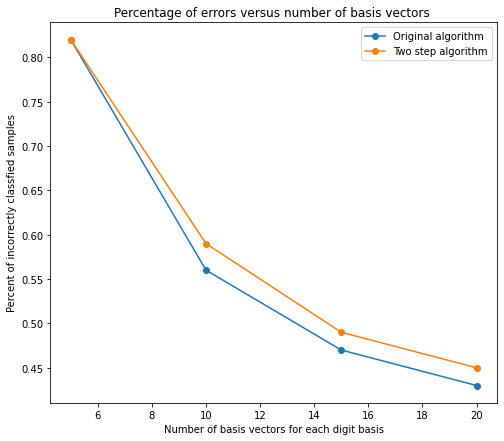

In [88]:
#Print comparison of quality of classifications
fig = plt.figure(figsize=(8, 7))
x=np.array(([5,10,15,20]))
plt.plot(x,(1/100*np.asarray(basis_performance)),'o-')
plt.plot(x,(1/100*np.asarray(basis_performance2)),'o-')
plt.title("Percentage of errors versus number of basis vectors ")
plt.xlabel("Number of basis vectors for each digit basis")
plt.ylabel("Percent of incorrectly classfied samples")
plt.legend(['Original algorithm','Two step algorithm'], loc='upper right')
plt.show()

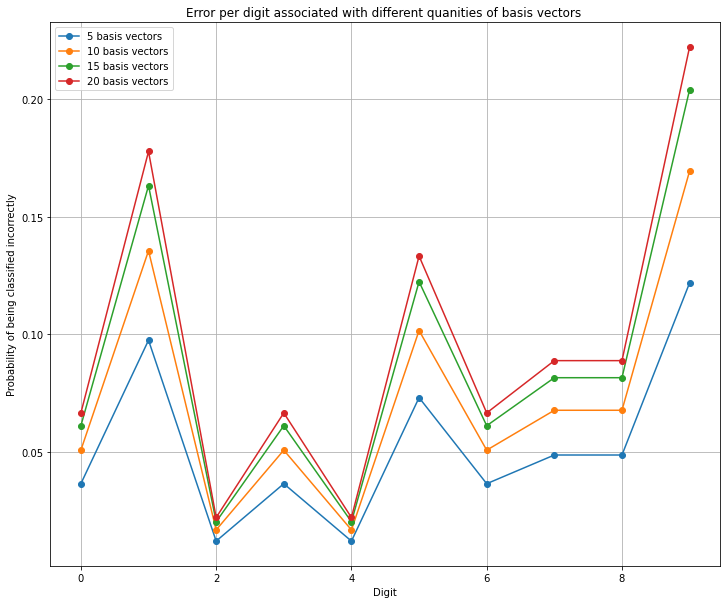

In [58]:

#show behavior of different basis for hybrid algorithm 
fig, ax = plt.subplots(figsize=(12, 10))
x=np.arange(10)
plt.title("Error per digit associated with different quanities of basis vectors ")
plt.xlabel("Digit")
plt.ylabel("Probability of being classified incorrectly")

ax.plot(x,Basis_errors[1],'o-',label ="5 basis vectors")
ax.plot(x,Basis_errors[2],'o-',label ="10 basis vectors")
ax.plot(x,Basis_errors[3],'o-',label ="15 basis vectors")
ax.plot(x,Basis_errors[4],'o-',label ="20 basis vectors")
plt.legend(['5 basis vectors', '10 basis vectors', '15 basis vectors', '20 basis vectors'], loc='upper left')
plt.grid()    
plt.show()